# Методы подбора гиперпараметров

Датасет: https://www.kaggle.com/c/bioresponse/data

### Дисклеймер:

1. Серебрянной пули – нет.
2. Параметров – много, а времени – мало.
3. Автоматический подбор параметров не всегда может спасти, см. предыдущий пункт.

In [1]:
from __future__ import print_function, division, unicode_literals

In [2]:
from tqdm import tqdm_notebook

In [3]:
import numpy as np
import pandas as pd

import scipy

from sklearn.model_selection import cross_val_score

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv('data/train.csv', sep=',')
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(3751, 1777)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = \
    train_test_split(df.iloc[:, 1:].values, df.iloc[:, 0].values, test_size=0.3, random_state=9876)

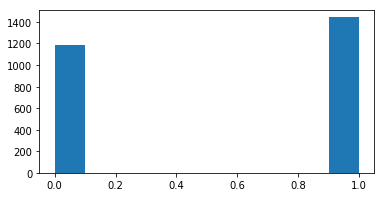

In [8]:
plt.figure(figsize=(6, 3))
_ = plt.hist(y_train)

In [9]:
from sklearn import linear_model, ensemble
from sklearn.metrics import roc_auc_score

## __1__. GridSearch

In [10]:
%%time

from sklearn.model_selection import GridSearchCV

params_grid = {
    'n_estimators': np.arange(50, 150, 25),
    'max_features': np.arange(0.5, 1.0, 0.1),
    'criterion':    ['gini', 'entropy'],
}

clf = ensemble.RandomForestClassifier()
model = GridSearchCV(estimator=clf, param_grid=params_grid, cv=3, verbose=5, n_jobs=16)
model.fit(X_train, y_train)

y_pred = model.best_estimator_.predict(X_valid)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:   56.4s
[Parallel(n_jobs=16)]: Done 114 out of 120 | elapsed:  2.7min remaining:    8.6s
[Parallel(n_jobs=16)]: Done 120 out of 120 | elapsed:  3.0min finished


CPU times: user 35.7 s, sys: 430 ms, total: 36.2 s
Wall time: 3min 35s


In [11]:
roc_auc_score(y_valid, y_pred)

0.7962612594085469

In [12]:
model.best_params_

{u'criterion': u'entropy', u'max_features': 0.5, u'n_estimators': 125}

## __2__. RandomizedSearch

In [13]:
%%time

from sklearn.model_selection import RandomizedSearchCV

params_grid = {
    'n_estimators': np.arange(50, 150, 25),
    'max_features': scipy.stats.uniform(loc=0.5, scale=0.5),
    'criterion':    ['gini', 'entropy'],
}

clf = ensemble.RandomForestClassifier()
model = RandomizedSearchCV(estimator=clf, param_distributions=params_grid,
                           n_iter=40, cv=3, verbose=5, n_jobs=16)
model.fit(X_train, y_train)

y_pred = model.best_estimator_.predict(X_valid)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 114 out of 120 | elapsed:  2.9min remaining:    9.0s
[Parallel(n_jobs=16)]: Done 120 out of 120 | elapsed:  3.3min finished


CPU times: user 17.1 s, sys: 103 ms, total: 17.2 s
Wall time: 3min 35s


In [14]:
roc_auc_score(y_valid, y_pred)

0.7962612594085469

In [15]:
model.best_params_

{u'criterion': u'entropy',
 u'max_features': 0.5856348213650988,
 u'n_estimators': 50}

<span style="color:blue;font-weight:bold">Вопрос:</span> чем `RandomizedSearchCV` лучше `GridSearchCV`?

## __3__. Sequential Model Optimization

Понятия:
* objective function – оптмизируемая функция, $f$;
* surrogate model – модель, которая приближает objective function;
* acquisition function – функция выгоды, по которой выбираем следующий набор гиперпараметров.

$$ \mathbf{P}(y|\theta, D) \rightarrow \max_\theta $$

Зададим acquisition function, как $a_f = \mathbf{E}[u(x)|D]$.

* $u(x) = \mathbf{I}(f(x) \leq f')$ – probability of improvement;
* $u(x) = max(f' - f(x), 0)$ – expected improvement.

Принцип работы:

1. Построим surrogate model для objective function.
2. Найдем новую точку (значение гиперпаметров), которые максимизируют acquisition function.
3. Посчитаем значение objective function в новой точке.
4. Обновим surrogate model.
5. Продолжаем выполнять шаги 2 – 4.

<img src="bayes_opt.png" width="620px">

### __3.1__. Гауссовские процессы

* [`bayesian-optimization`](https://github.com/fmfn/BayesianOptimization);
* [`scikit-optimize`](https://scikit-optimize.github.io/);
* [`gpyopt`](http://sheffieldml.github.io/GPyOpt/).

[Ссылка](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) на статью.

In [16]:
%%time

from bayes_opt import BayesianOptimization

def model_auc_score(**params):
    params['n_estimators'] = int(round(params['n_estimators']))
    params['max_depth'] = int(round(params['max_depth']))
    
    clf = ensemble.GradientBoostingClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=3).mean()
    return score

bounds = {
    'learning_rate': (0.001, 0.1),
    'n_estimators':  (50, 200),
    'subsample':     (0.5, 1.0),
    'max_depth':     (3, 8),
}

optimizer = BayesianOptimization(
    f=model_auc_score,
    pbounds=bounds,
    random_state=9872,
)

optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8318   |  0.004349 |  4.043    |  68.09    |  0.7578   |
|  2        |  0.8595   |  0.04405  |  4.174    |  190.7    |  0.5446   |
|  3        |  0.863    |  0.05816  |  5.209    |  132.8    |  0.5512   |
|  4        |  0.8532   |  0.04029  |  3.765    |  128.8    |  0.8575   |
|  5        |  0.8624   |  0.06198  |  6.307    |  143.4    |  0.7496   |
|  6        |  0.8654   |  0.07328  |  7.5      |  192.9    |  0.8587   |
|  7        |  0.8608   |  0.02739  |  5.351    |  174.2    |  0.5119   |
|  8        |  0.86     |  0.08097  |  5.369    |  78.44    |  0.6074   |
|  9        |  0.8598   |  0.07345  |  7.147    |  62.34    |  0.6088   |
|  10       |  0.8623   |  0.01712  |  6.997    |  172.0    |  0.6901   |
|  11       |  0.8601   |  0.07012  |  7.97     |  103.9    |  0.5202   |
|  12       |  0.8596   |  0.0917   | 

In [17]:
optimizer.max

{'params': {u'learning_rate': 0.07327706465626922,
  u'max_depth': 7.4996252276945805,
  u'n_estimators': 192.88607838095453,
  u'subsample': 0.8587300335514458},
 'target': 0.8654007615036979}

In [18]:
%%time

from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical

space = [
    Real(0.001, 0.1, prior='log-uniform', name=str('learning_rate')),
    Integer(50, 200, name=str('n_estimators')),
    Real(0.5, 1.0, prior='uniform', name=str('subsample')),
    Integer(3, 8, name=str('max_depth')),
]

@use_named_args(space)
def objective(**params):
    clf = ensemble.GradientBoostingClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=3).mean()
    return -score

res = gp_minimize(objective, space, n_random_starts=10, n_calls=30, verbose=1, random_state=9872)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 23.3231
Function value obtained: -0.8199
Current minimum: -0.8199
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 20.8933
Function value obtained: -0.8507
Current minimum: -0.8507
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 99.1970
Function value obtained: -0.8453
Current minimum: -0.8507
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 37.6817
Function value obtained: -0.8618
Current minimum: -0.8618
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 43.5716
Function value obtained: -0.8587
Current minimum: -0.8618
Iteration No: 6 star

In [19]:
res.x

[0.040075301537003276, 200, 0.7144733192022844, 8]

In [20]:
res.fun

-0.8687320509124627

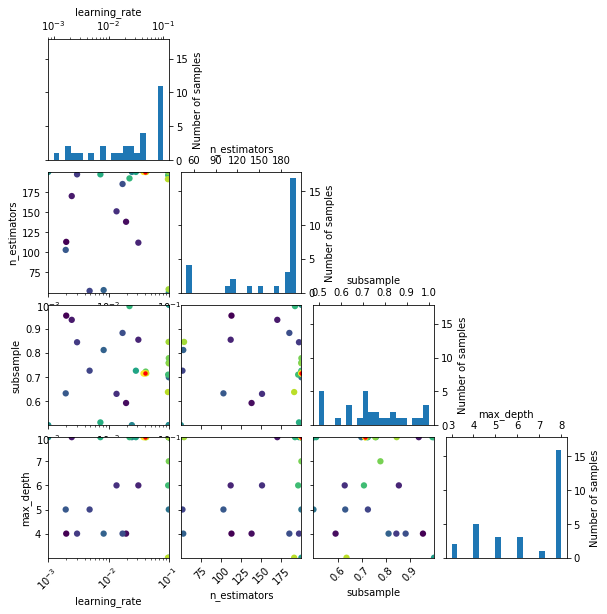

In [21]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(res, dimensions=[s.name for s in space])

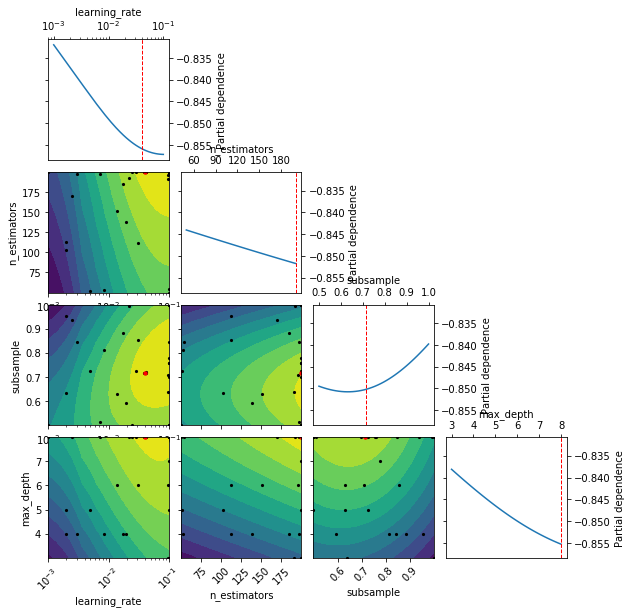

In [22]:
from skopt.plots import plot_objective

_ = plot_objective(res, dimensions=[s.name for s in space])

<span style="color:red;font-weight:bold">Недостатки:</span>

* проблема холодного старта;
* плохо работает в случае категориальных и дискретных параметров;
* сильно подвержен проклятию размерности.

Для <span style="color:green;font-weight:bold">решения</span> проблемы холодного старта неплохо подойдут RandomizedSearch и GridSearch.

### __3.2__. Деревья

Чисто технически ничто не мешает заменить расчет параметров, среднее и матрицу ковариации, гауссовского процесса на что-то другое, например, на деревья.

* [`scikit-optimize`](https://scikit-optimize.github.io/).

In [23]:
from skopt import forest_minimize, gbrt_minimize

**Tree-Structured Parzen Estimators**

Идея: перейдем от рассмотрения $ \mathbf{P}(y|\theta, D) $ к $ \mathbf{P}(\theta|y, D) $.

$$ \mathbf{P}(\theta|y, D) = \left\{\begin{matrix}
l(x); & y < y^*  \\ 
g(x); & y \geq y^*
\end{matrix}\right. $$

где
* $l(x)$ – генеративное распределение, построенное на основе наблюдений $\{x_i | f(x_i) < y^*\}$;
* $g(x)$ – генеративное распределение, построенное на основе остальных наблюдений;
* $y^*$ – выборочный квантиль порядка $\gamma$.

Распределения $l(x)$ и $g(x)$ моделируются с помощью ядерной оценки плотности (KDE или Parzen density estimation).

Оказывается, что в этом случае для expected improvement справедливо
$$ a_f \propto \left(\gamma + \frac{g(x)}{l(x)} (1 - \gamma) \right)^{-1} $$

<span style="color:blue;font-weight:bold">Вопрос:</span> что означает такое выражение для expected improvement?

Библиотеки:
* [`hyperopt`](http://hyperopt.github.io/hyperopt/);
* [`optuna`](https://optuna.org/).

In [24]:
%%time

from hyperopt import fmin, tpe, hp, Trials

space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'n_estimators':  hp.uniformint('n_estimators', 50, 200),
    'subsample':     hp.uniform('subsample', 0.5, 1.0),
    'max_depth':     hp.choice('max_depth', range(3, 9)),
}

def objective(params):
    clf = ensemble.GradientBoostingClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=3).mean()
    return -score

trials = Trials()
res = fmin(objective, space, algo=tpe.suggest, max_evals=40, trials=trials,
           rstate=np.random.RandomState(9872), verbose=1)

100%|██████████| 40/40 [27:08<00:00, 40.70s/it, best loss: -0.865981366662]
CPU times: user 1.73 s, sys: 1.15 s, total: 2.88 s
Wall time: 27min 8s


In [25]:
res

{u'learning_rate': 0.05832837481015358,
 u'max_depth': 4,
 u'n_estimators': 171.0,
 u'subsample': 0.6332457454311889}

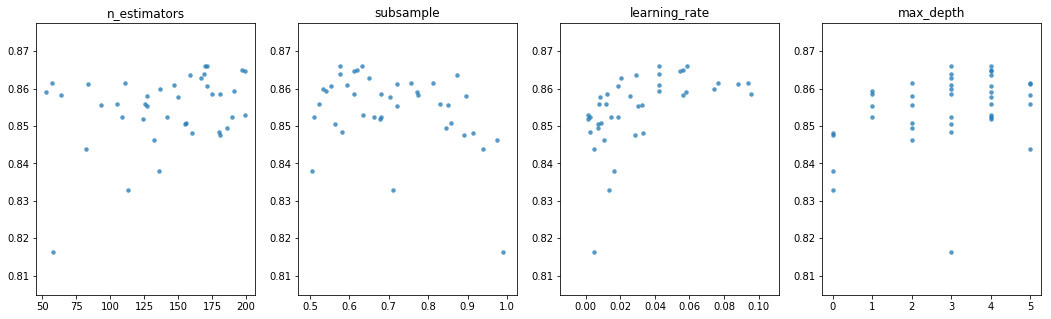

In [26]:
f, axes = plt.subplots(nrows=1, ncols=len(space), figsize=(18, 5))

for ax, val in zip(axes, space):
    xs = [t['misc']['vals'][val] for t in trials.trials]
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
    ax.set_title(val)